In [ ]:
from IPython.utils import io

with io.capture_output() as captured:
    import os
    import time
    import cdsapi
    import concurrent.futures
    import logging
    import sys

    base_directory = "/home/juantuf/Descargas/eraland_00_01/"
    log_file_path = "/home/juantuf/Descargas/last_download.txt"
    log_file_all = "/home/juantuf/Descargas/all_logs.txt"

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[logging.FileHandler(log_file_all)])

    def generate_filename(year, month, day, hour):
        return os.path.join(base_directory, f"ERA.{year}{month:02d}{day:02d}{hour:02d}.levels.grib")

    def log_last_download(file_path):
        with open(log_file_path, 'w') as log_file:
            log_file.write(f"Last downloaded file: {file_path}\n")

    def download_file(year, month, day, hour):
        file_path = generate_filename(year, month, day, hour)
        download_successful = False
        attempts = 0
        max_attempts = 3
        
        while not download_successful and attempts < max_attempts:
            try:
                c.retrieve(
                    'reanalysis-era5-land',
                    {
                        'variable': [
                            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
                            '2m_temperature', 'surface_pressure', 'surface_solar_radiation_downwards',
                            'surface_thermal_radiation_downwards', 'total_precipitation',
                        ],
                        'year': str(year),
                        'month': f"{month:02d}",
                        'day': f"{day:02d}",
                        'time': f"{hour:02d}:00",
                        'area': [
                            -10, -77, -12, -75,
                        ],
                        'format': 'grib',
                    },
                    file_path
                )
                time.sleep(5)
                
                if os.path.exists(file_path):
                    file_size = os.path.getsize(file_path)
                    if file_size > 0:
                        download_successful = True
                        log_last_download(file_path)
                    else:
                        time.sleep(1)
                        attempts += 1
                else:
                    time.sleep(1)
                    attempts += 1
                    
            except Exception as e:
                with open(log_file_all, 'a') as log_file:
                    log_file.write(f"Error downloading file: {e}. Retrying...\n")
                time.sleep(1)
                attempts += 1
        
        if not download_successful:
            with open(log_file_all, 'a') as log_file:
                log_file.write(f"Failed to download file after {max_attempts} attempts: {file_path}\n")

    years = [2008]
    months = [1]

    c = cdsapi.Client(timeout=100000, quiet=True)

    tasks = []
    for year in years:
        for month in months:
            for day in range(1, 32):
                for hour in range(24):
                    tasks.append((year, month, day, hour))

    def download_task_wrapper(task):
        year, month, day, hour = task
        download_file(year, month, day, hour)
        time.sleep(10)

    def chunk_tasks(tasks, chunk_size):
        for i in range(0, len(tasks), chunk_size):
            yield tasks[i:i + chunk_size]

    chunk_size = 24  
    for task_chunk in chunk_tasks(tasks, chunk_size):
        with concurrent.futures.ThreadPoolExecutor(max_workers=chunk_size) as executor:
            futures = [executor.submit(download_task_wrapper, task) for task in task_chunk]
            for future in concurrent.futures.as_completed(futures):
                future.result()
        time.sleep(10)


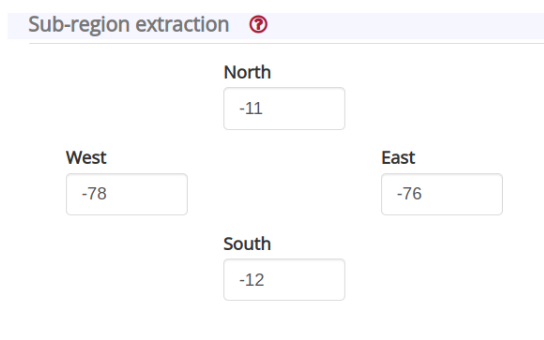